In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor, Button
from scipy import signal
import math
import os

directory  = 'data/Research_B/Data/'
AllHeartbeats = []
AllPeaks = []
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if os.path.isfile(f):
        
        highest_peak_values = []
        highest_peak_indices = []

        data = []
        RMSSD = []

        with open(f, 'r') as file:
            data_started = False
            for line in file:
                # Check if the line contains data
                if data_started:
                    values = line.strip().split()
                    data.append([int(val) for val in values])
                elif line.strip() == "# EndOfHeader":
                    data_started = True

            # Convert the data into a NumPy array
            data = np.array(data)

            heartbeat_data = data[:, 2]

            #Toggle inverse heartbeatdata
            if False:
                heartbeat_data = -heartbeat_data

            heightthreshold = 150  # Adjust this threshold as needed
            widthtreshold = 200


            #Butterworth filter
            sos = signal.butter(2, 3, 'highpass',fs = 1000, output = 'sos')
            filtered = signal.sosfilt(sos, heartbeat_data)

            # Create an array for the x-axis (time)
            time = np.arange(len(heartbeat_data))

            peaks, _ = signal.find_peaks(filtered, height=heightthreshold, distance= widthtreshold)
            AllHeartbeats.append(heartbeat_data)
            AllPeaks.append(peaks)
            print(count, end=' ')
            count += 1


        



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

In [90]:
#--------------------- Nieuwe berekening -------------------------
interval = 29000  # Meettijd per HRV waarde (ms)
waarde1 = 0
waarde2 = interval
All_HRV = []

def calculate_rmssd(heartbeat_data, peaks):
    HRVRMSSD = []
    waarde1 = 0
    waarde2 = interval
    
    for i in range(int((len(heartbeat_data) - interval) / 1000)):
        peaks_in_range_interval = [peak for peak in peaks if waarde1 <= peak <= waarde2]
        RMSSD = [math.pow(heartbeat_data[peaks[j+1]] - heartbeat_data[peaks[j]], 2) for j, peak in enumerate(peaks_in_range_interval)]
        HRVcount = sum(RMSSD)
        HRVRMSSD.append(HRVcount / (len(peaks_in_range_interval) - 1))
        waarde1 += 1000
        waarde2 += 1000
    
    waarde1 = 0
    waarde2 = interval
    return HRVRMSSD

# Voer de functie uit om HRVRMSSD te berekenen
count = 0
for peaks in AllPeaks:
    HRVRMSSD = calculate_rmssd((AllHeartbeats[count]), peaks)
    All_HRV.append(HRVRMSSD)
    print(count, end=' ')
    count += 1
print('')
print((All_HRV[0]))

'''
# Plot de HRV data met de RMSSD formule
# Maak een figuur en as-object
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVRMSSD, label='HRV - RMSSD')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - Nieuw RMSSD')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)
ax.legend()
'''


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
[2709.657894736842, 2709.657894736842, 2709.657894736842, 2709.657894736842, 2701.135135135135, 2701.135135135135, 2709.657894736842, 2701.135135135135, 2701.135135135135, 2701.135135135135, 2751.1666666666665, 2751.1666666666665, 2751.1666666666665, 2751.1666666666665, 2719.942857142857, 2719.942857142857, 2751.1666666666665, 2719.942857142857, 2719.942857142857, 2751.1666666666665, 2751.1666666666665, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2769.823529411765, 2769.823529411765, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2769.823529411765, 2719.942857142857, 2719.942857142857, 2719.942857142857, 2751.1666666666665, 2751.1666666666665, 2719.942857142857, 2751.1666666666665, 2751.1666666666665, 2751.1666666666665, 2751.1666666666665, 2751.16666666

'\n# Plot de HRV data met de RMSSD formule\n# Maak een figuur en as-object\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Voeg de lijnplot toe aan de as\nax.plot(HRVRMSSD, label=\'HRV - RMSSD\')\n\n# Stel de titel en labels in\nax.set_xlabel(\'Time (Row Index)\')\nax.set_ylabel(\'Amplitude\')\nax.set_title(\'HRV data - Nieuw RMSSD\')\n\n# Voeg een raster en een legenda toe\nax.grid(True)\nax.legend()\n\nax.set_xlim(0, 1500)\n\nax.axvspan(180, 330, color="red", alpha=0.3)\nax.axvspan(330, 570, color="green", alpha=0.3)\nax.axvspan(570, 720, color="red", alpha=0.3)\nax.axvspan(720, 960, color="green", alpha=0.3)\nax.axvspan(960, 1110, color="red", alpha=0.3)\nax.axvspan(1110, 1350, color="green", alpha=0.3)\nax.legend()\n'

In [91]:
#Calculate HRV with RMSSD

interval = 30000 #Meettijd per HRV waarde (ms)
All_HRV2 = []
def calculate_rmssd2(heartbeat_data, peaks):

    HRVRMSSD2 = []
    waarde1 = 0
    waarde2 = interval
    HRVcount = 0
    q = 0
    RMSSD2 = []
    peaks_in_range_interval = 0
    peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

    for i in range(int((len(heartbeat_data)-interval)/1000)):
        #Neem de kwadraten van de verschillen tussen de waardes
        for j in range(peaks_in_range_interval, peaks_in_range_interval2):
            RMSSD2.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+q+1]] - heartbeat_data[peaks[peaks_in_range_interval+q]], 2)) #heartbeat_data vervangen door pieken
            q = q+1

        #Tel verkregen waardes bij elkaar op
        HRVcount = sum(RMSSD2)

        #Deel deze waarde door het totaal aantal waardes -1
        HRVRMSSD2.append(HRVcount/(peaks_in_range_interval2-1))

        #Reset variabelen
        HRVcount = 0
        q = 0
        RMSSD2 = []
        
        #Verschuif het window met 1 seconden (1000 ms)
        waarde1 = waarde1 + 1000
        waarde2 = waarde2 + 1000
        peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
        peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])
    return HRVRMSSD2

count = 0
for peaks in AllPeaks:
    HRVRMSSD2 = calculate_rmssd2((AllHeartbeats[count]), peaks)
    All_HRV2.append(HRVRMSSD2)
    print(count, end=' ')
    count += 1
print('')
print((All_HRV2[500]))
    
#plot de HRV data met de RMSSD formule
# Maak een figuur en as-object
'''
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVRMSSD, label='HRV - RMSSD')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - RMSSD')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)

plt.show()
'''

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 


IndexError: list index out of range

In [ ]:
#Calculate HRV with SDNN

All_HRV3 = []
def calculate_sdnn(heartbeat_data, peaks):
    waarde1 = 0
    waarde2 = interval
    peaks_in_range_interval = 0
    peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

    SDNNGem = 0
    SDNN = []
    HRVSDNN = []
    SDNNV = 0

    r=0

    for i in range(int((len(heartbeat_data)-interval)/1000)):
        #Tel meetwaardes bij elkaar op en deel deze door het aantal waardes om het gemiddelde te berekenen.
        for j in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNNGem += heartbeat_data[peaks[peaks_in_range_interval]]
        SDNNGem = SDNNGem/(peaks_in_range_interval2 - peaks_in_range_interval)

        #Bereken de afwijking per meetwaarde ten opzichte van het gemiddelde en neem hier het kwadraat van
        for g in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNN.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+r]] - SDNNGem, 2)) #heartbeat_data vervangen door pieken
            r = r+1

        #Tel de gekwadrateerde afwijkingen bij elkaar op en deel deze door het aantal meet meetwaardes, en neem hier vervolgens de wortel van
        SDNNV = sum(SDNN)
        HRVSDNN.append(math.sqrt(SDNNV/len(SDNN)))

        #Reset variabelen
        r = 0
        SDNNGem = 0
        SDNNV = 0
        SDNN = []

        #Verschuif het window met 1 seconden (1000 ms)
        waarde1 = waarde1 + 1000
        waarde2 = waarde2 + 1000
        peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
        peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])
    return HRVSDNN

count = 0
for peaks in AllPeaks:
    HRVSDNN = calculate_sdnn((AllHeartbeats[count]), peaks)
    All_HRV3.append(HRVSDNN)
    print(count, end=' ')
    count += 1
print('')
print((All_HRV3[0]))

'''
# Maak een figuur en as-object
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVSDNN, label='HRV - SDNN')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - SDNN')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)

plt.show()
'''

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
[61.005597504075546, 43.38375271919201, 46.4580455895424, 61.2172361349318, 132.07777429052345, 97.71617061674081, 38.57654727940281, 42.789286941044914, 53.28371088948147, 42.23712062835674, 69.44270641099907, 46.07797182146245, 51.59457335805772, 45.677358205478335, 79.45472958895559, 37.852205664719335, 36.66024664688614, 37.717656629510024, 49.77581319222588, 52.9165181652841, 41.707628987865924, 69.78325517416555, 63.23327738162124, 35.6408511440211, 41.68608556496676, 49.24909830860385, 34.720505663275034, 64.94675573946, 42.327232304919185, 43.15528216080134, 46.32134137378436, 52.075568790603384, 50.04565483203879, 32.96271439885588, 36.21071963129449, 29.67025993017797, 42.59552063748462, 65.39960327179446, 74.78213971967259, 62.98684073092695, 40.77634763334977, 26.213696701092008, 41.40461454069048, 30.55667727871912, 37.21799950533998, 26.220723021867144, 38.42080028756353, 30

'\n# Maak een figuur en as-object\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Voeg de lijnplot toe aan de as\nax.plot(HRVSDNN, label=\'HRV - SDNN\')\n\n# Stel de titel en labels in\nax.set_xlabel(\'Time (Row Index)\')\nax.set_ylabel(\'Amplitude\')\nax.set_title(\'HRV data - SDNN\')\n\n# Voeg een raster en een legenda toe\nax.grid(True)\nax.legend()\n\nax.set_xlim(0, 1500)\n\nax.axvspan(180, 330, color="red", alpha=0.3)\nax.axvspan(330, 570, color="green", alpha=0.3)\nax.axvspan(570, 720, color="red", alpha=0.3)\nax.axvspan(720, 960, color="green", alpha=0.3)\nax.axvspan(960, 1110, color="red", alpha=0.3)\nax.axvspan(1110, 1350, color="green", alpha=0.3)\n\nplt.show()\n'

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          500000    
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 617377 (2.36 MB)
Trainable params: 617377 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
176/176 [==============================] - 93s 518ms/step - loss: 0.5172 - accuracy: 0.7388 - val_loss: 0.3743 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 2/2
196/196 [==============================] - 15s 77ms/step - loss: 0.3521 - accuracy: 0.8514
Accuracy: 0.8514
Loss: 

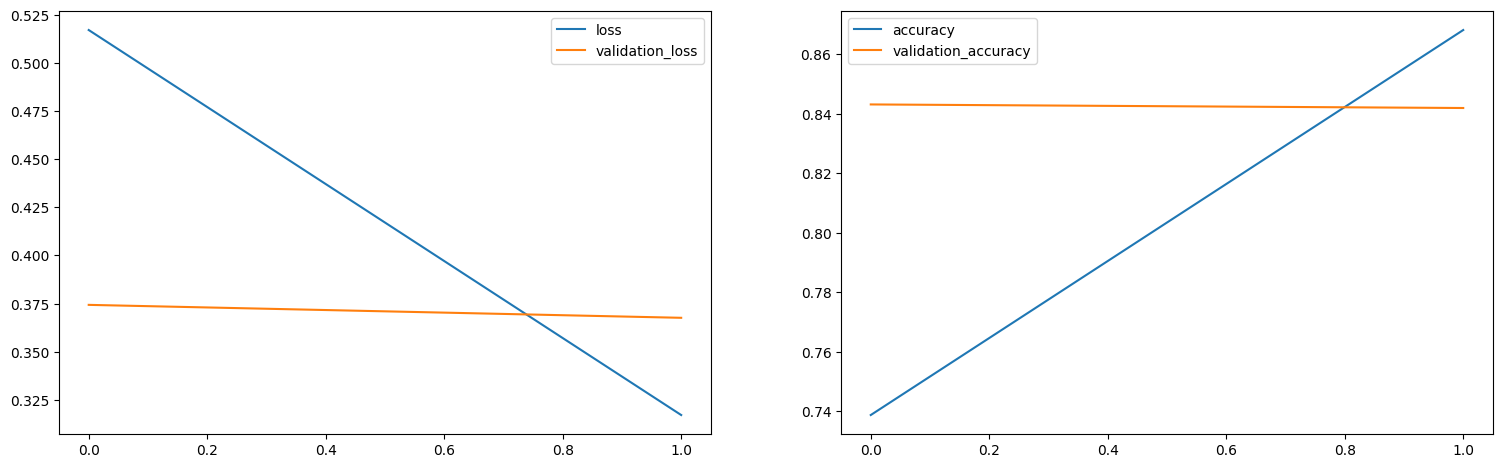

In [14]:
# Long - Short Term Memory  ---  Recurring Neural Network (AI Model)

import pandas as pd

import numpy as np

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve

from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.layers import Activation, Dense, Dropout, Embedding, LSTM

import re

from IPython.display import display

import os

import string

import time

import random

import matplotlib.pyplot as plt

from keras.datasets import imdb

from keras.layers import Embedding

random.seed(10)



num_words = 5000

( X_train , y_train ),( X_test , y_test ) = imdb.load_data(num_words = 5000)

sequence_length = 300

batch_size = 128

X_train_seq = pad_sequences( X_train, maxlen = sequence_length)

X_test_seq = pad_sequences( X_test, maxlen = sequence_length)

encoder = LabelEncoder()

encoder.fit(y_train)

y_train_transformed = encoder.transform(y_train).reshape(-1,1)

y_test_transformed = encoder.transform(y_test).reshape(-1,1)

model = Sequential()

embedding_dim = 100  # Dimensie van de embedding-vector

model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length))

model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))

model.add(Dense(1, activation = 'sigmoid' ))

model.summary()

model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

early_stopper = EarlyStopping( monitor = 'val_accuracy' , min_delta = 0.0005, patience = 3 )

reduce_lr = ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)

callbacks = [ reduce_lr , early_stopper]

train_history = model.fit( X_train_seq , y_train_transformed , batch_size = batch_size, epochs = 2,validation_split = 0.1 , verbose = 1 , callbacks = callbacks)

score = model.evaluate( X_test_seq , y_test_transformed , batch_size = batch_size)

print( "Accuracy: {:0.4}".format( score[1] ))

print( "Loss:", score[0] )

y_pred = model.predict( X_test_seq )

print('Accuracy: {:0.3}'.format(100 * accuracy_score(y_test_transformed, 1 * (y_pred > 0.5))))

print(' f1 score: {:0.3}'.format( 100*f1_score( y_test_transformed , 1 * ( y_pred > 0.5))))

print(' ROC AUC: {:0.3}'.format( roc_auc_score( y_test_transformed , y_pred)) )

print( classification_report( y_test_transformed , 1 * ( y_pred > 0.5 ),digits = 3) )

loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']
accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']


fig = plt.gcf() 

fig.set_size_inches(18.5, 5.5)

plt.subplot(1,2,1)

plt.plot(loss)

plt.plot(validation_loss)

plt.legend(['loss', 'validation_loss'])

plt.subplot(1,2,2)

plt.plot(accuracy)

plt.plot(val_accuracy)

plt.legend(['accuracy', 'validation_accuracy'])

plt.show()